# Hyper-parameters

In [169]:
batch_size = 16
learning_rate = 0.005
epochs = 20
shuffle_flag = True
loss_choice = 'cross_entropy'
weigths = [0.9, 1, 1, 1, 1, 0.9, 1, 1]
model_choice = 'resnet'

val_percentage = 0.1
h_crop = 256
w_crop = 256
rot_angle = 30
rot_flag = True
shear_angle = 30
shear_flag = True
pixel_translate = 50
translate_flag = True
vflip_flag = True
hflip_flag = True

num_classes = 8

binary_encoded = [[0, 0, 0],[0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
one_hot_encoded = [[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1]]

# Import

In [170]:
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
import imageio

import os
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score

import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF

import random

from sklearn.model_selection import train_test_split

!pip install torchsummary
from torchsummary import summary

!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [20]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [21]:
torch.cuda.is_available()

True

---

# Studying the dataset

In [171]:

train_img_path = "../cv_lab5/dataset/images"
train_mask_path = "../cv_lab5/dataset/masks"

test_img_path = "../cv_lab5/TEST/images"
test_mask_path = "../cv_lab5/TEST/masks"

In [172]:
image_paths = sorted(glob(os.path.join(train_img_path, '*')))
mask_paths = sorted(glob(os.path.join(train_mask_path, '*')))

C:\Users\compf\AppData\Local\Temp\ipykernel_19716\2359442444.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_paths[i])
C:\Users\compf\AppData\Local\Temp\ipykernel_19716\2359442444.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_paths[i])


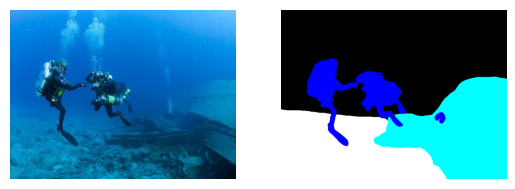

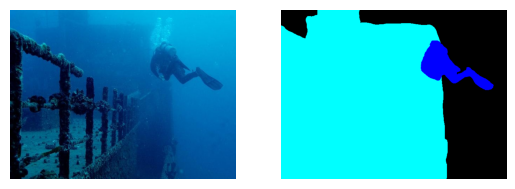

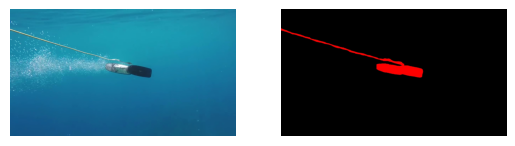

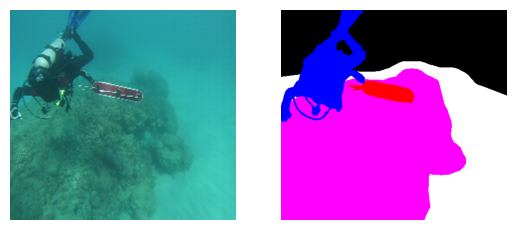

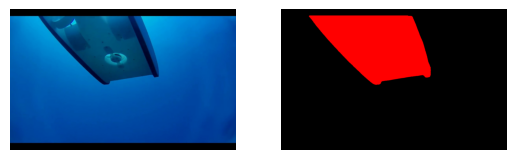

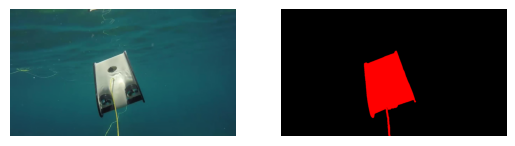

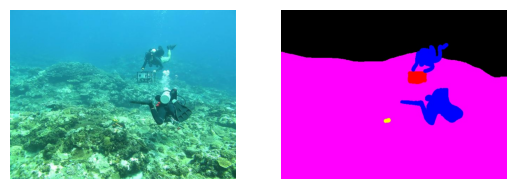

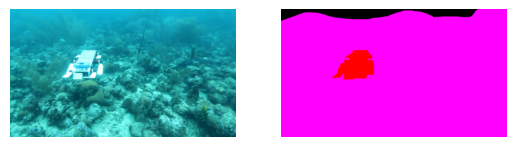

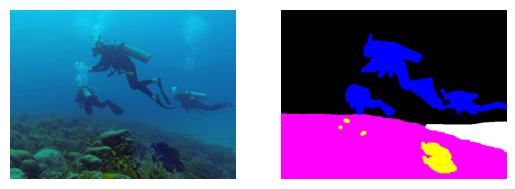

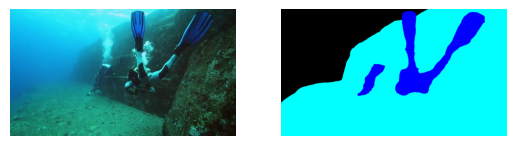

In [173]:

for i in range(0,10):
    img = imageio.imread(image_paths[i])
    mask = imageio.imread(mask_paths[i])
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.axis('off')
    plt.show()

In [174]:
def bin2ohe(mask, num_class, binary_encoded, one_hot_encoded):
    mask = mask.permute(1,2,0)
    mask = mask.numpy()
    mask = mask.astype(np.int64)
    h,w = mask.shape[:-1]
    layout = np.zeros((h, w, num_class), dtype=np.int64)
    for i, label in enumerate(binary_encoded):
        layout[np.all(mask == label, axis = -1)] = one_hot_encoded[i]
    layout = layout.astype(np.float64)
    layout = torch.from_numpy(layout)
    layout = layout.permute(2,0,1)
    return layout
            
def ohe2bin(mask, one_hot_encoded, binary_encoded):
    mask = mask.permute(1,2,0)
    mask = mask.numpy()
    h,w = mask.shape[:-1]
    layout = np.zeros((h,w,3), dtype=np.int64)
    for i, label in enumerate(one_hot_encoded):
        layout[np.all(mask == label, axis = -1)] = binary_encoded[i]
        
    layout = layout.astype(np.float64)
    layout = torch.from_numpy(layout)
    layout = layout.permute(2,0,1)
    return layout

def argmax_predict(pred):
    pred = F.softmax(pred, dim=1)
    pred = pred.numpy()
    
    for img in range(pred.shape[0]):
        tmp_pred = pred[img]
        pred_arg = np.argmax(tmp_pred, axis=0)
        layout = np.zeros((h_crop, w_crop, num_classes))

        for i in range(0,num_classes):
            layout[pred_arg == i] = one_hot_encoded[i]
        layout = np.transpose(layout, (2,0,1))
        pred[img] = layout
    return pred

## Plot functions

In [175]:
def plot_img_label(img, label):
    
    img = img.permute(1, 2, 0)


    test_mask_rgb = ohe2bin(label, one_hot_encoded, binary_encoded)
    test_mask_rgb = test_mask_rgb.permute(1, 2, 0)
        
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(test_mask_rgb * 1.0)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        plt.subplot(2,4,i + 1)
        plt.axis('off')
        plt.title(f'class {i:03b}')
        plt.imshow(label[i,:,:], cmap='gray')
    plt.show()
    
def plot_img_label_pred(img, label, pred):
    # pred 
    pred = pred.permute(1,2,0)
    pred = pred.numpy()
    
    pred_arg = np.argmax(pred, axis=2)
    layout = np.zeros((h_crop, w_crop, 3))
    
    for i in range(0,num_classes):
        layout[pred_arg == i] = binary_encoded[i]
    
    
    img = img.permute(1, 2, 0)

    
    test_mask_rgb = ohe2bin(label, one_hot_encoded, binary_encoded)
    test_mask_rgb = test_mask_rgb.permute(1, 2, 0)
        
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(test_mask_rgb * 1.0)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(layout * 1.0)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        plt.subplot(2,4,i + 1)
        plt.axis('off')
        plt.title(f'class {i:03b}')
        plt.imshow(label[i,:,:], cmap='gray')
    plt.show()
    
    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        plt.subplot(2,4,i + 1)
        plt.axis('off')
        plt.title(f'class {i:03b}')
        plt.imshow(pred[:,:,i], cmap='gray')
    plt.show()

# DataLoader

In [176]:
class SuimDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, transform_flag=True, hflip=False, vflip=False, rotate=False, shear=False, translate=False):
        self.image_paths = imgs_dir
        self.mask_paths = masks_dir
        self.transform_flag = transform_flag
        self.hflip = hflip
        self.vflip = vflip
        self.rotate = rotate
        self.shear = shear
        self.translate = translate
        
    def transform(self, image, mask):
        # random angle interval
        rot_interval = [-rot_angle, rot_angle]
        shear_interval = [-shear_angle, shear_angle]
        translate_interval = [-pixel_translate, pixel_translate]
        
        ran_angle = 0
        ran_translate_x, ran_translate_y = 0, 0
        ran_shear_angle = 0

        
        image = TF.resize(image, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)
        mask = TF.resize(mask, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)
        
       
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = torch.round(mask)
                
        if self.transform_flag:         
            image = TF.pad(image, padding=h_crop//2, padding_mode="reflect")
            mask = TF.pad(mask, padding=h_crop//2, padding_mode="reflect")
            
            if self.hflip:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            
            if self.vflip:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            if self.rotate:
                ran_angle = random.uniform(rot_interval[0], rot_interval[1])
            if self.shear:
                ran_shear_angle = random.uniform(shear_interval[0], shear_interval[1])
            if self.translate:
                ran_translate_x = random.uniform(translate_interval[0], translate_interval[1])
                ran_translate_y = random.uniform(translate_interval[0], translate_interval[1])

       
            image = TF.affine(image, angle=ran_angle, translate=(ran_translate_x,ran_translate_y), scale=1, shear=ran_shear_angle, interpolation=T.InterpolationMode.NEAREST)
            mask = TF.affine(mask, angle=ran_angle, translate=(ran_translate_x,ran_translate_y), scale=1, shear=ran_shear_angle, interpolation=T.InterpolationMode.NEAREST)
        
            cropper = T.CenterCrop(size=[h_crop,w_crop])

            image = cropper(image)
            mask = cropper(mask)
        
      
        layout = bin2ohe(mask, num_classes, binary_encoded, one_hot_encoded)
        return image, layout
        
    def __getitem__(self, index):
        
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.mask_paths[index])
        
        image, mask = self.transform(image, mask)
        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [177]:
train_split_img, val_split_img, train_split_mask, val_split_mask = train_test_split(image_paths, mask_paths, test_size=val_percentage)

dataset1 = SuimDataset(train_split_img, train_split_mask, transform_flag = False)
dataset2 = SuimDataset(train_split_img, train_split_mask, transform_flag = True, hflip=hflip_flag, rotate=rot_flag, shear=shear_flag, translate=translate_flag)
dataset3 = SuimDataset(train_split_img, train_split_mask, transform_flag = True, vflip=vflip_flag, rotate=rot_flag, shear=shear_flag, translate=translate_flag)
dataset4 = SuimDataset(train_split_img, train_split_mask, transform_flag = True, hflip=hflip_flag, vflip=vflip_flag, rotate=rot_flag, shear=shear_flag, translate=translate_flag)

dataset = torch.utils.data.ConcatDataset([dataset1, dataset2, dataset3, dataset4])


dataset_val = SuimDataset(val_split_img, val_split_mask, transform_flag = False)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_flag)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=shuffle_flag)

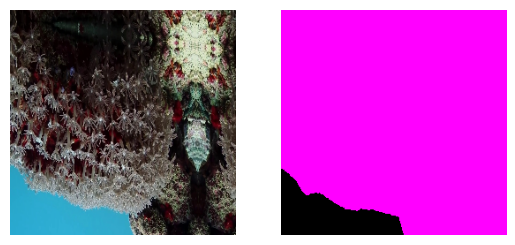

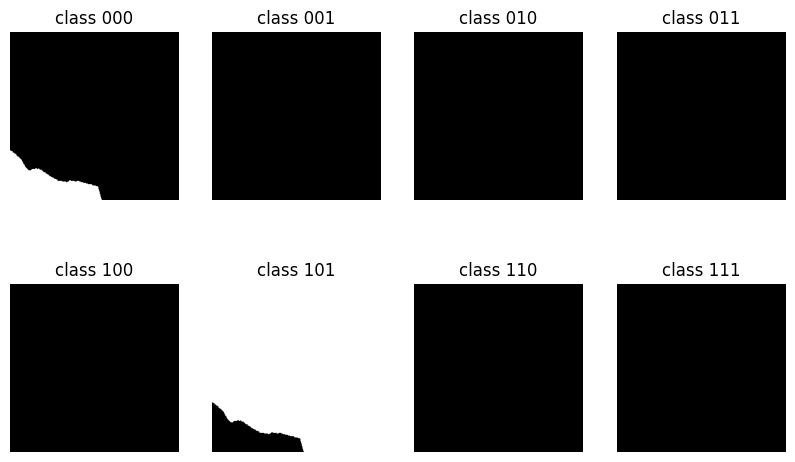

In [178]:
ran_idx = np.random.randint(0, len(image_paths))

image = Image.open(image_paths[ran_idx])
mask = Image.open(mask_paths[ran_idx])

img,mask = dataset4.transform(image,mask)

plot_img_label(img, mask)

# Unet

In [179]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    

class UNet(nn.Module):
    
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32))
        self.down2 = (Down(32, 64))
        self.down3 = (Down(64, 128))
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor))

        self.up1 = (Up(256, 128 // factor, bilinear))
        self.up2 = (Up(128, 64 // factor, bilinear))
        self.up3 = (Up(64, 32 // factor, bilinear))
        self.up4 = (Up(32, 16, bilinear))
        self.outc = (OutConv(16, n_classes))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
#         x = self.softmax(x)
        return x

# ResnetUnet

In [180]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet34(weights = models.ResNet34_Weights.IMAGENET1K_V1)
        
        self.base_layers = list(base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [181]:
# res_unet = smp.Unet(
#     encoder_name="resnet34",        
#     encoder_weights="imagenet",     
#     in_channels=3,                  
#     classes=num_classes,            
# )

In [182]:
res_unet = ResNetUNet(num_classes)

In [183]:
summary(res_unet.cuda(), (3, h_crop, w_crop))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           9,408
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          36,864
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [184]:
if model_choice == 'resnet':
    model = res_unet

In [185]:
model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

# Metrics

In [186]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        
        inputs = F.softmax(inputs, dim=1)       
        
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [187]:

class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):     
        
#         inputs = F.softmax(inputs, dim=1)
        
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        iou = (intersection + smooth)/(union + smooth)
                
        return iou
    
iou_metrics = IoU()

In [188]:
def IoU_by_class(inputs, target, smooth=1):
    iou_s = []
    for img in range(inputs.size()[0]):
        tmp = []
        for channel in range(inputs.size()[1]):
            flat_pred = inputs[channel].view(-1)
            flat_target = target[channel].view(-1)

            intersection = (flat_pred * flat_target).sum()
            total = (flat_pred + flat_target).sum()
            union = total - intersection 

            iou = (intersection + smooth)/(union + smooth)
            tmp.append(iou.numpy())
        iou_s.append(tmp)
    return iou_s

In [189]:
def Pixel_accuracy(inputs, target):

  y_pred_argmax = inputs.argmax(dim=1)
  y_true_argmax = target.argmax(dim=1)

  correct_pixels = (y_pred_argmax == y_true_argmax).count_nonzero()
  uncorrect_pixels = (y_pred_argmax != y_true_argmax).count_nonzero()
  pixel_acc = (correct_pixels / (correct_pixels + uncorrect_pixels)).item()

  return pixel_acc

# Training

In [190]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2.1.0+cu121
True
NVIDIA GeForce RTX 3070 Laptop GPU
cuda:0


In [191]:
if loss_choice ==  'dice':
    loss = DiceLoss()
elif loss_choice == 'cross_entropy':
    loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(weigths).cuda())
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, )
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [94]:
# model = torch.load('resnet_best_loss.pt')

In [192]:
import time
from tqdm import tqdm
def train(epochs, model, train_loader, val_loader, loss_fn, metrics, optimizer, checkpoint=True):
    torch.cuda.empty_cache()
    
    model.to(device)
    tic_tot = time.time()
    train_losses = []
    val_losses = [] 
    train_iou = []
    val_iou = []
    best_loss = np.inf
    best_val_loss = np.inf
   
    for e in range(epochs):
        tic = time.time()
     
        running_loss = 0
        
       
        iou_score = 0
        
       
        model.train(True)
        
       
        for (x_train, y_train) in tqdm(train_loader):
            
        
            x_train = x_train.cuda()
            y_train = y_train.cuda()
            
           
            optimizer.zero_grad()
            
          
            output = model(x_train)
            
          
            loss = loss_fn(output, y_train)            
            loss.backward()
            
          
            optimizer.step()
    
          
            running_loss += loss.item()
          
#             iou_score += metrics(output, y_train).cpu()

#         plot_img_label_pred(x_train.detach().cpu()[0], y_train.detach().cpu()[0], output.detach().cpu()[0])
            
      
        val_running_loss = 0    
        val_iou_score = 0
        
       
        for (x_val, y_val) in tqdm(val_loader):
           
            
            x_val = x_val.cuda()
            y_val = y_val.cuda()
            model.eval()
            
            output = model(x_val)
                
          
            loss = loss_fn(output, y_val)            
           
            val_running_loss += loss.item()
          
#             val_iou_score +=  metrics(output, y_val).cpu()
            
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_running_loss/len(val_loader))
        
#         val_iou.append(val_iou_score/len(val_loader))
#         train_iou.append(iou_score/len(train_loader))
      
        toc = time.time()
        print("Epoch:{}/{}..".format(e+1, epochs),
              "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
              "Val Loss: {:.3f}..".format(val_running_loss/len(val_loader)),
              "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
              "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
              "Time: {:.2f}m".format((toc-tic)/60))
        if checkpoint:
            if running_loss/len(train_loader) < best_loss:
                torch.save(model, f'{model_choice}_best_loss_34_imnet_2.pt')
                best_loss = running_loss/len(train_loader)
                print("Saving best loss model")
            if val_running_loss/len(val_loader) < best_val_loss:
                torch.save(model, f'{model_choice}_best_val_loss_34_imnet_2.pt')
                best_val_loss = val_running_loss/len(val_loader)
                print("saving best val loss model")
 
    history = {
        'train_losses' : train_losses,
        'val_losses': val_losses,
        'train_iou': train_iou,
        'val_iou':val_iou,
    }
    toc_tot = time.time()
    print(f'Total training time: {toc_tot - tic_tot}')
    torch.save(model, f'{model_choice}_last_34_imnet_2.pt')    
    return history

In [193]:
history = train(epochs, model, train_loader, val_loader, loss, iou_metrics, optimizer)

100%|██████████| 10/10 [00:39<00:00,  3.98s/it]


Epoch:1/20.. Train Loss: 1.153.. Val Loss: 0.925.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 44.44m
Saving best loss model
saving best val loss model


100%|██████████| 10/10 [00:37<00:00,  3.74s/it]


Epoch:2/20.. Train Loss: 0.812.. Val Loss: 0.714.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 37.25m
Saving best loss model
saving best val loss model


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Epoch:3/20.. Train Loss: 0.705.. Val Loss: 0.599.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 33.73m
Saving best loss model
saving best val loss model


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Epoch:4/20.. Train Loss: 0.656.. Val Loss: 0.623.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.26m
Saving best loss model


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Epoch:5/20.. Train Loss: 0.644.. Val Loss: 0.602.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 34.94m
Saving best loss model


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Epoch:6/20.. Train Loss: 0.621.. Val Loss: 0.576.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.26m
Saving best loss model
saving best val loss model


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Epoch:7/20.. Train Loss: 0.613.. Val Loss: 0.597.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 34.90m
Saving best loss model


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Epoch:8/20.. Train Loss: 0.593.. Val Loss: 0.711.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.25m
Saving best loss model


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Epoch:9/20.. Train Loss: 0.585.. Val Loss: 0.684.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 34.75m
Saving best loss model


100%|██████████| 10/10 [00:40<00:00,  4.09s/it]


Epoch:10/20.. Train Loss: 0.563.. Val Loss: 0.679.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.26m
Saving best loss model


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Epoch:11/20.. Train Loss: 0.566.. Val Loss: 0.611.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.04m


100%|██████████| 10/10 [00:37<00:00,  3.80s/it]


Epoch:12/20.. Train Loss: 0.547.. Val Loss: 0.627.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 34.98m
Saving best loss model


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Epoch:13/20.. Train Loss: 0.536.. Val Loss: 0.627.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 34.93m
Saving best loss model


100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


Epoch:14/20.. Train Loss: 0.510.. Val Loss: 0.559.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.43m
Saving best loss model
saving best val loss model


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Epoch:15/20.. Train Loss: 0.504.. Val Loss: 0.650.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.11m
Saving best loss model


100%|██████████| 10/10 [00:38<00:00,  3.85s/it]


Epoch:16/20.. Train Loss: 0.512.. Val Loss: 0.602.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.46m


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


Epoch:17/20.. Train Loss: 0.502.. Val Loss: 0.665.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.16m
Saving best loss model


100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


Epoch:18/20.. Train Loss: 0.487.. Val Loss: 0.647.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.47m
Saving best loss model


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Epoch:19/20.. Train Loss: 0.477.. Val Loss: 0.570.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.11m
Saving best loss model


100%|██████████| 10/10 [00:39<00:00,  3.92s/it]


Epoch:20/20.. Train Loss: 0.475.. Val Loss: 0.614.. Train mIoU:0.000.. Val mIoU: 0.000.. Time: 35.49m
Saving best loss model
Total training time: 42796.638758182526


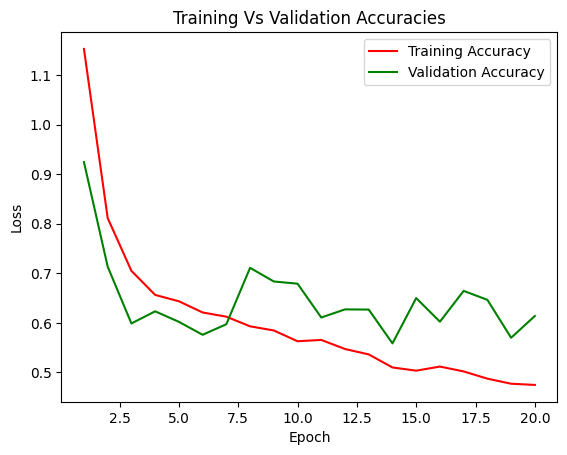

In [195]:

plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1, len(history['train_losses'])+1)), history['train_losses'], color='r', label="Training Accuracy")
plt.plot(list(range(1, len(history['val_losses'])+1)), history['val_losses'], color='g', label="Validation Accuracy")
plt.legend()
plt.savefig("training_loss.png")

# Test

In [196]:
class SuimTestDataset(Dataset):

    def __init__(self, imgs_dir, masks_dir):
        self.image_paths = sorted(glob(os.path.join(imgs_dir, '*')))
        self.mask_paths = sorted(glob(os.path.join(masks_dir, '*.bmp')))
        
    def transform(self, image, mask):
        image = TF.resize(image, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)
        mask = TF.resize(mask, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        layout = bin2ohe(mask, num_classes, binary_encoded, one_hot_encoded)
        return image, layout
        
    def __getitem__(self, index):
        
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.mask_paths[index])
        
        image, mask = self.transform(image, mask)
        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [197]:
def test_model(model):
    test_dataset = SuimTestDataset(test_img_path, test_mask_path)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = model.cuda()
    iou_scores = []
    iou_bychannel = []
    pixel_acc_scores = []
    for idx,(x_test, y_test) in enumerate(test_loader):
        x_test = x_test.cuda()
        y_test = y_test.cuda()

        model.eval()

        with torch.no_grad():
            pred = model(x_test)

        pred = argmax_predict(pred.cpu())
        iou_by_class = IoU_by_class(torch.from_numpy(pred).cpu(), y_test.cpu())

        iou_score = iou_metrics(torch.from_numpy(pred), y_test.cpu())
        iou_scores.append(iou_score.cpu())

        pixel_acc = Pixel_accuracy(torch.from_numpy(pred).cpu(), y_test.cpu())
        pixel_acc_scores.append(pixel_acc)

       
        idx = np.random.randint(0,pred.shape[0])

        
        img = x_test.cpu()
        label = y_test.cpu()
        plot_img_label_pred(img[idx], label[idx], torch.from_numpy(pred[idx]))
        iou_bychannel.append(np.mean(iou_by_class, axis=0))

    print(f"Test IoU = {np.mean(iou_scores)}")    
    print(f"Channel IoU = {np.mean(iou_bychannel, axis=0)}")    
    print(f"Test Pixel Accuracy = {np.mean(pixel_acc_scores)}")    
    
    return np.mean(iou_scores), np.mean(iou_bychannel, axis=0), np.mean(pixel_acc_scores)


# Encoder ResNet_34 pretrained on imagenet v1, Decoder Unet

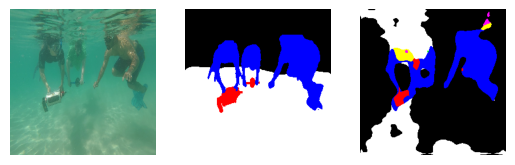

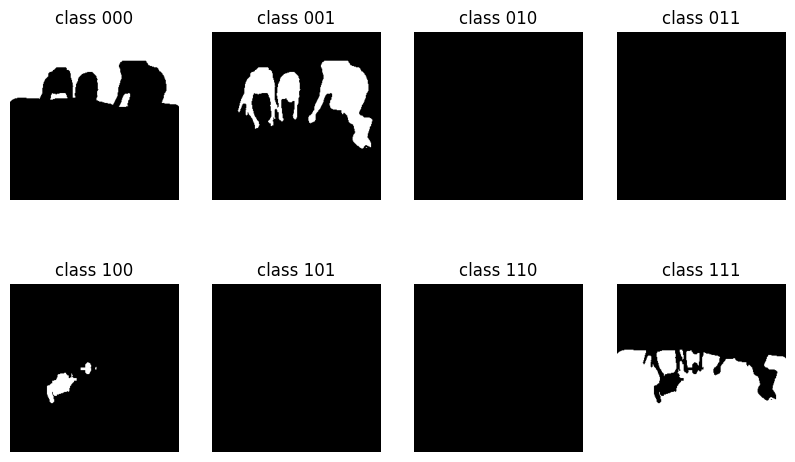

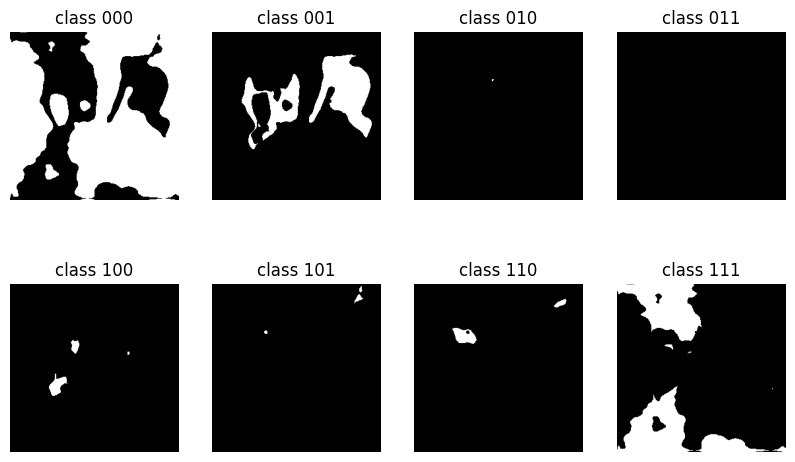

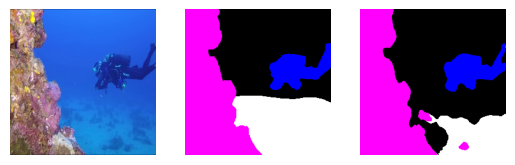

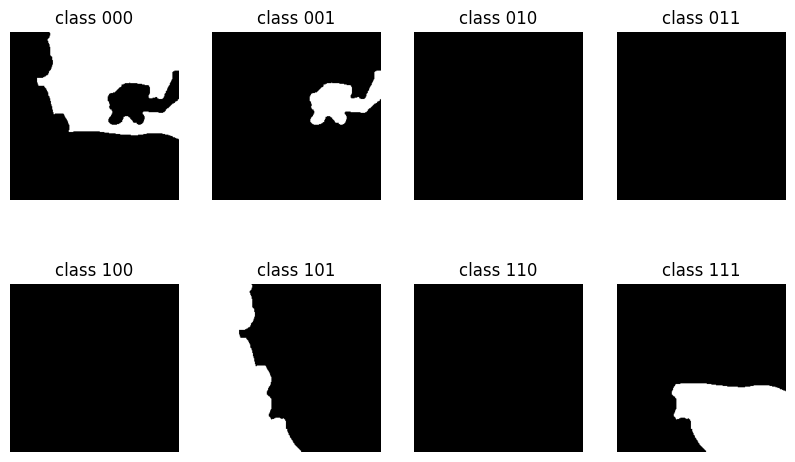

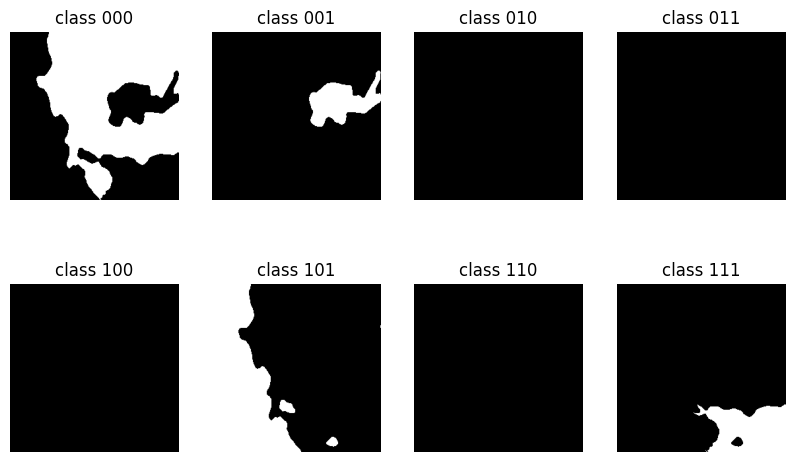

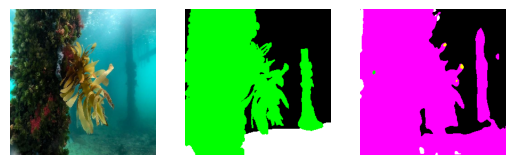

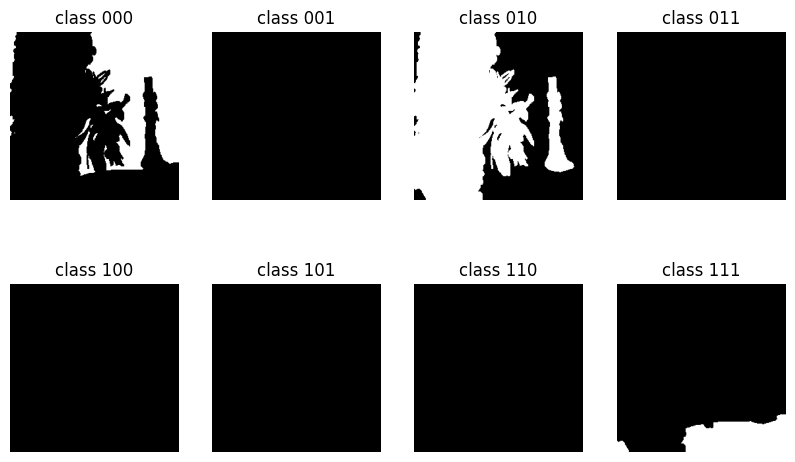

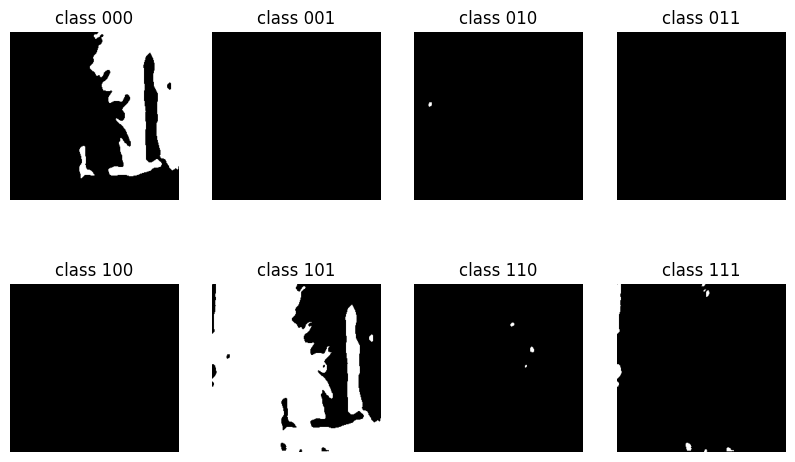

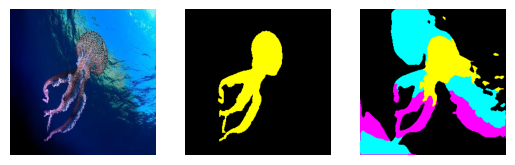

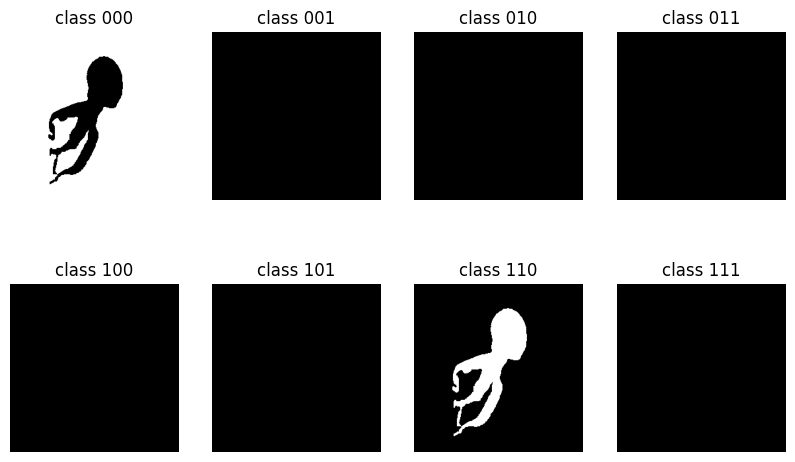

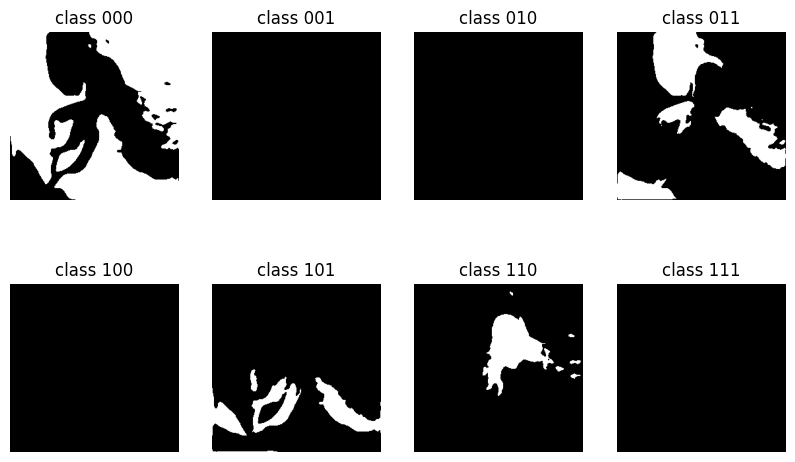

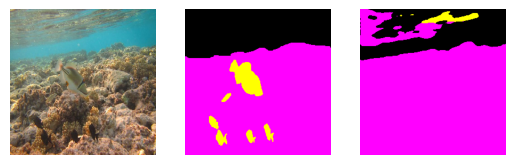

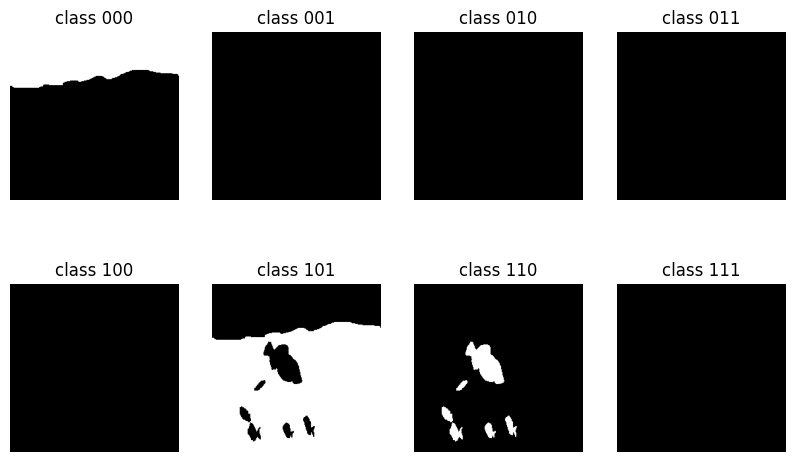

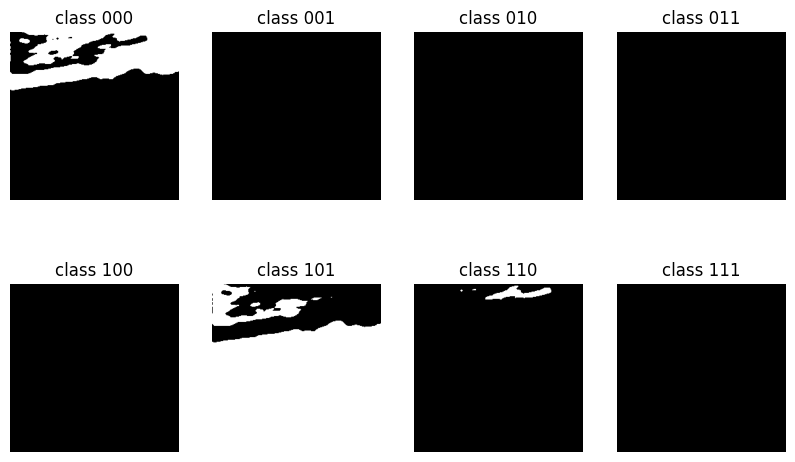

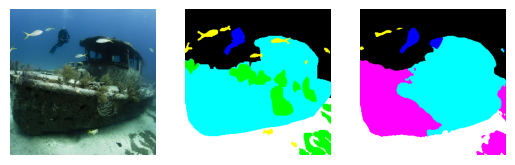

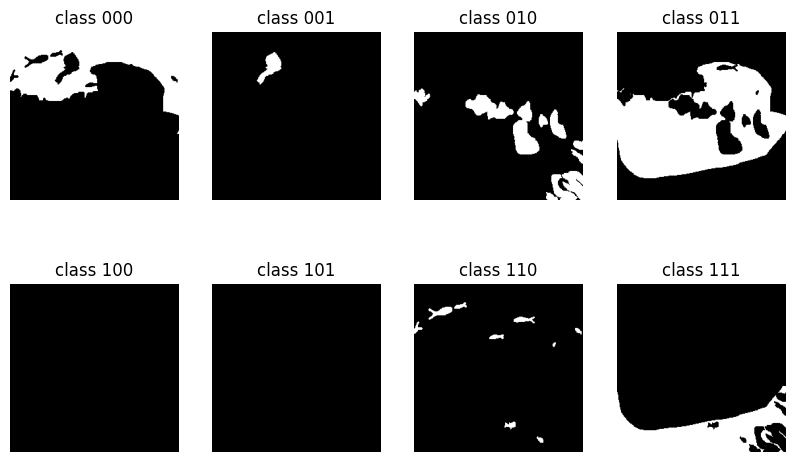

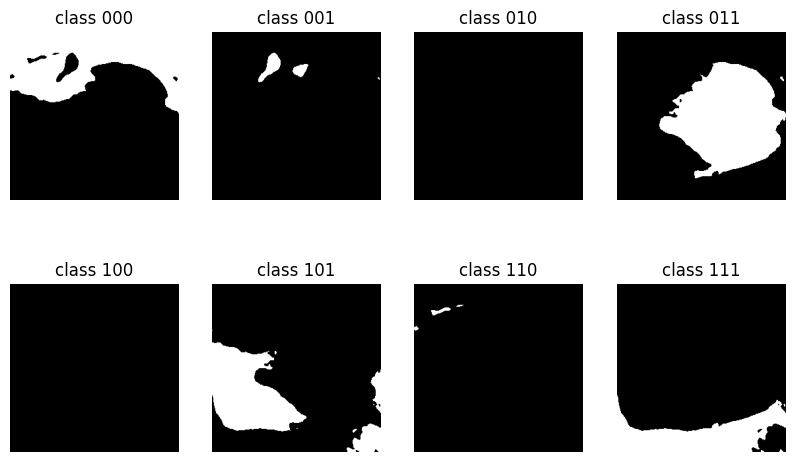

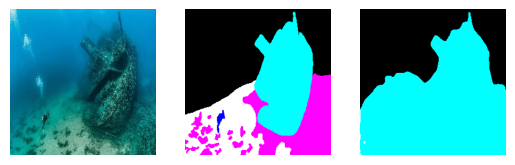

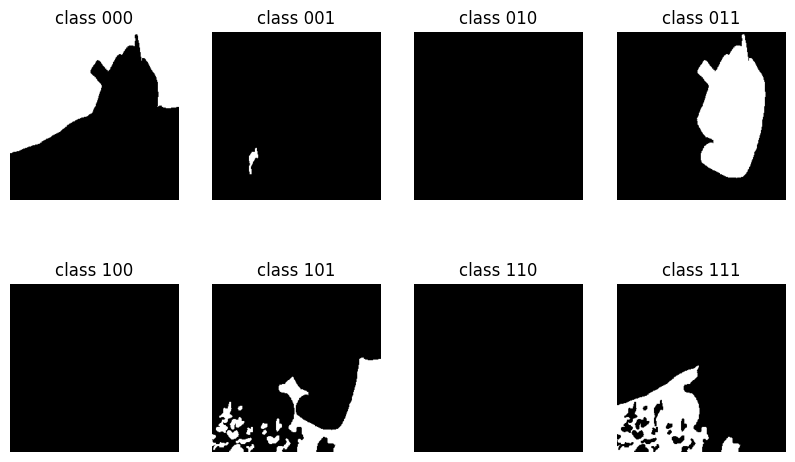

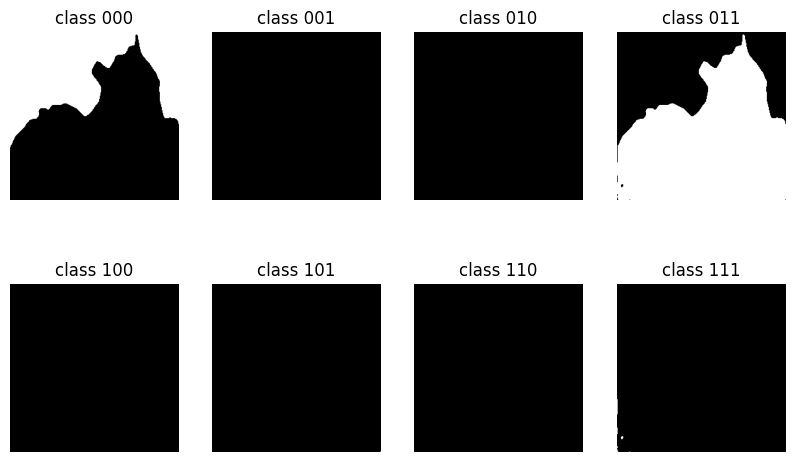

Test IoU = 0.6183505483044043
Channel IoU = [0.67742041 0.63122334 0.62681932 0.60970667 0.70306627 0.58129923
 0.60147009 0.57830763]
Test Pixel Accuracy = 0.7618201885904584


ValueError: too many values to unpack (expected 2)

In [155]:
model = torch.load(f'resnet_best_loss_34_imnet.pt')
iou_scores_last, iou_bychannel_last = test_model(model)

# Unet

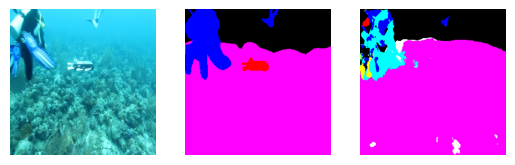

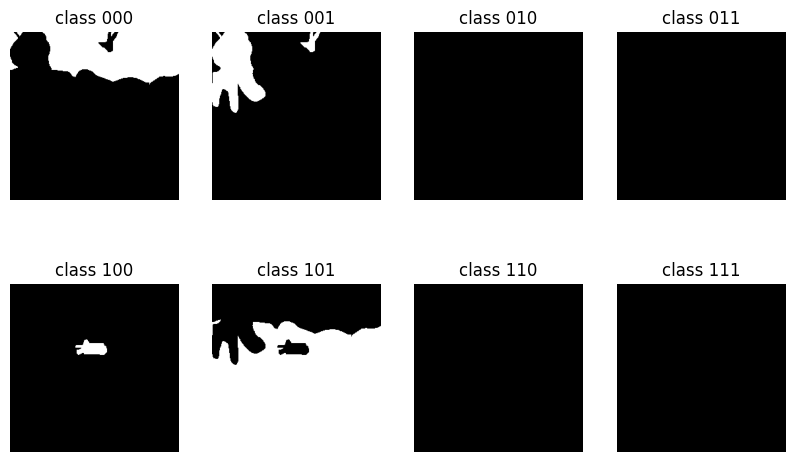

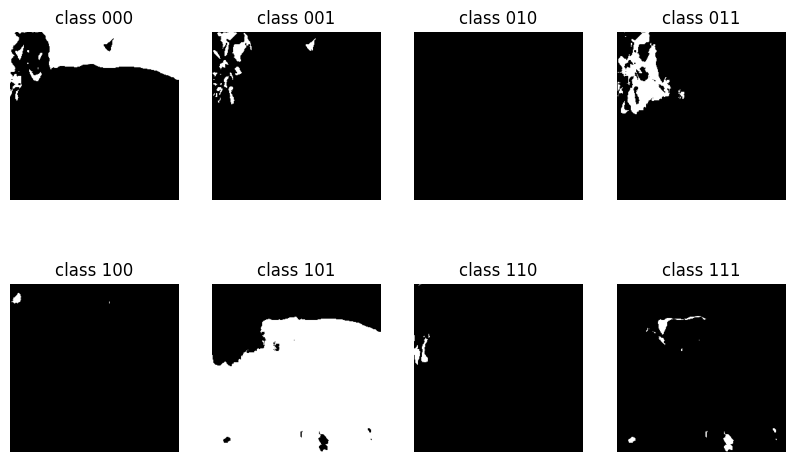

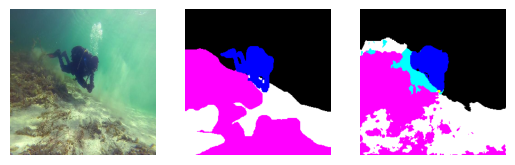

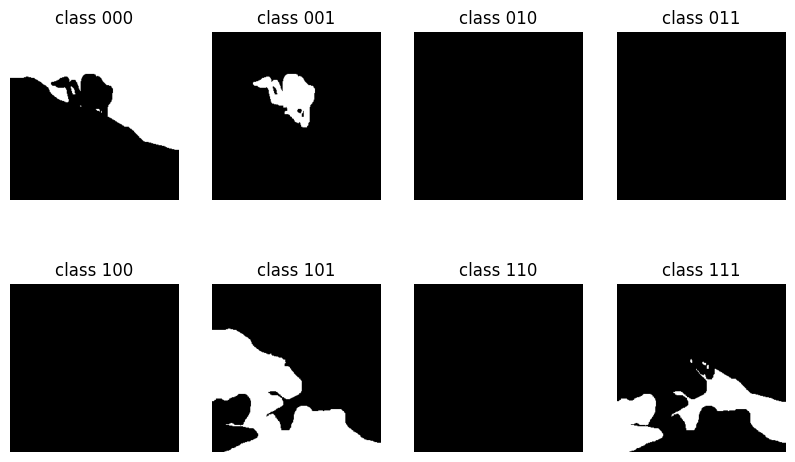

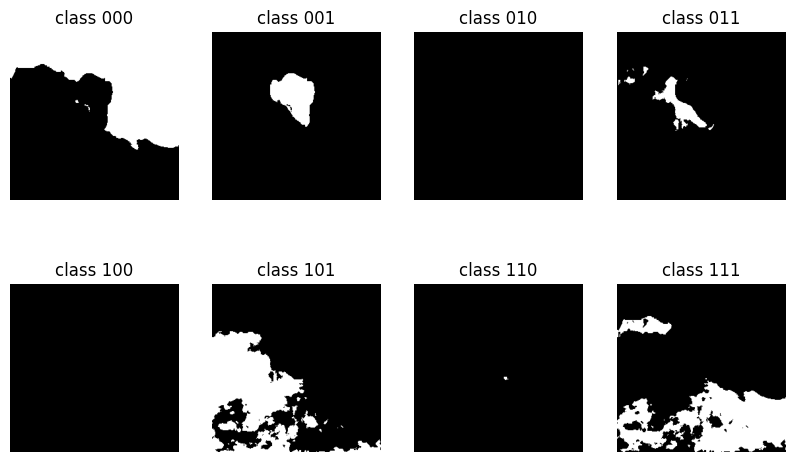

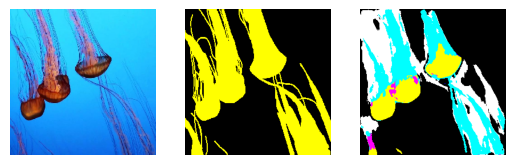

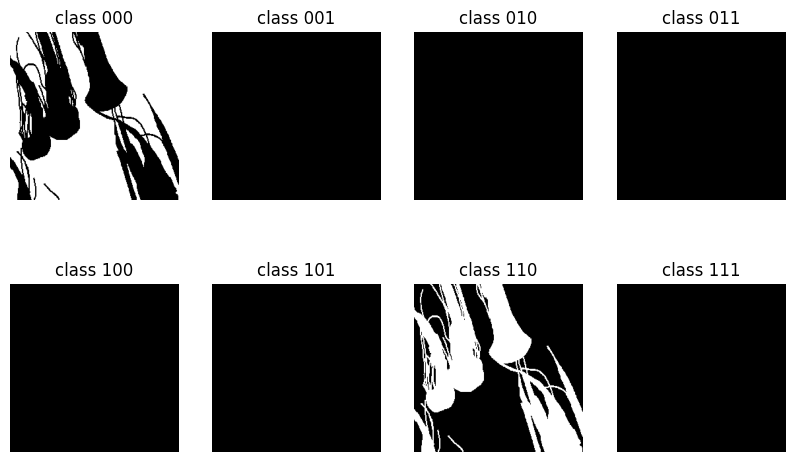

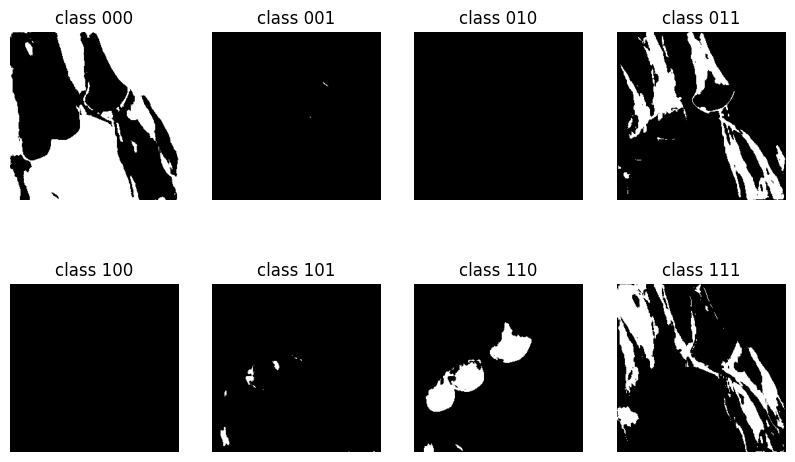

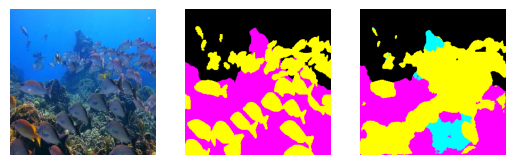

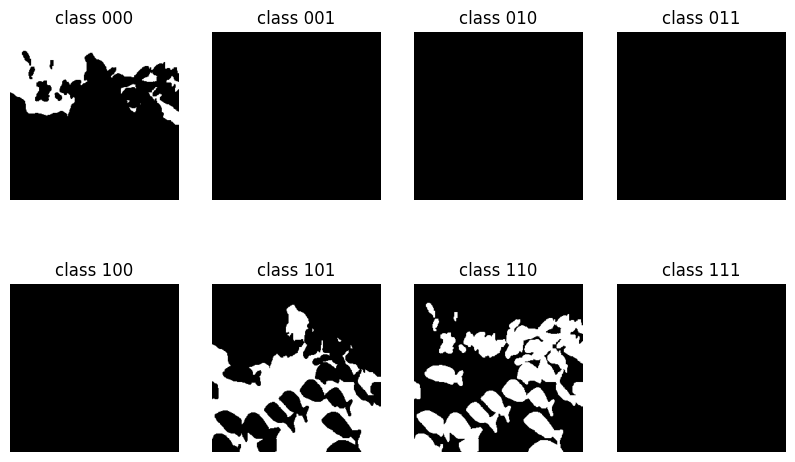

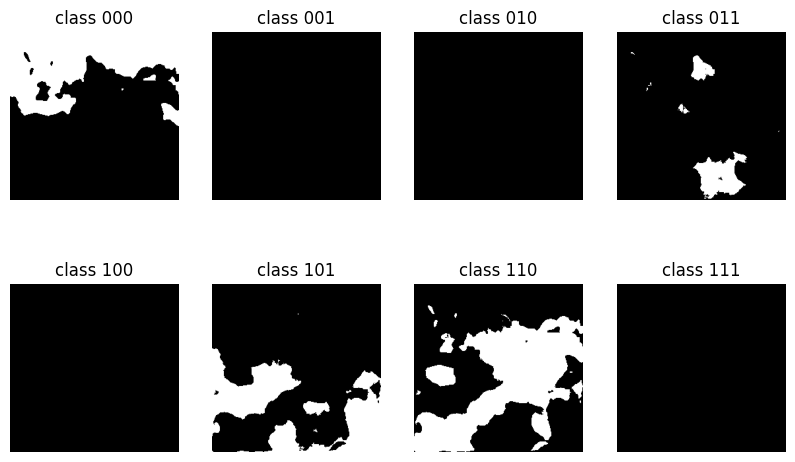

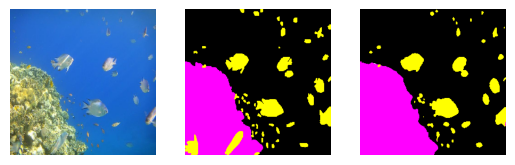

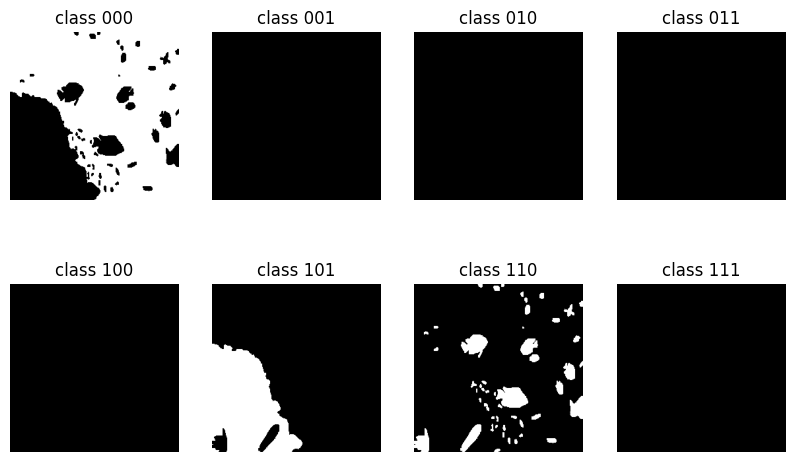

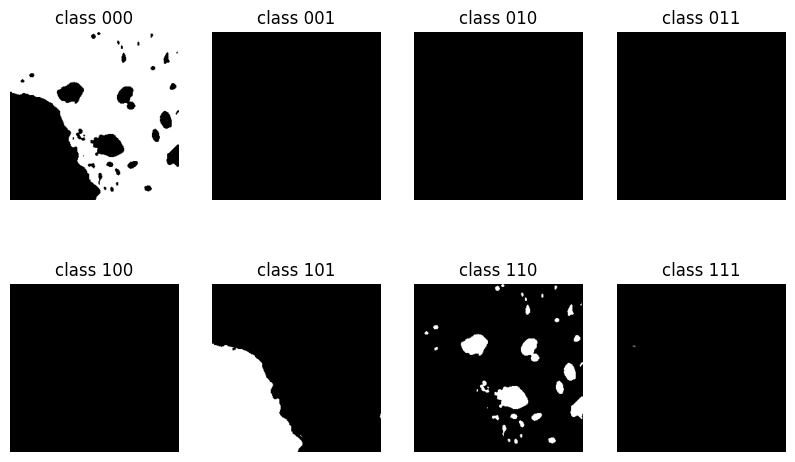

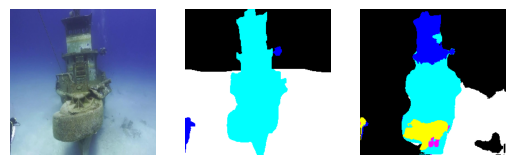

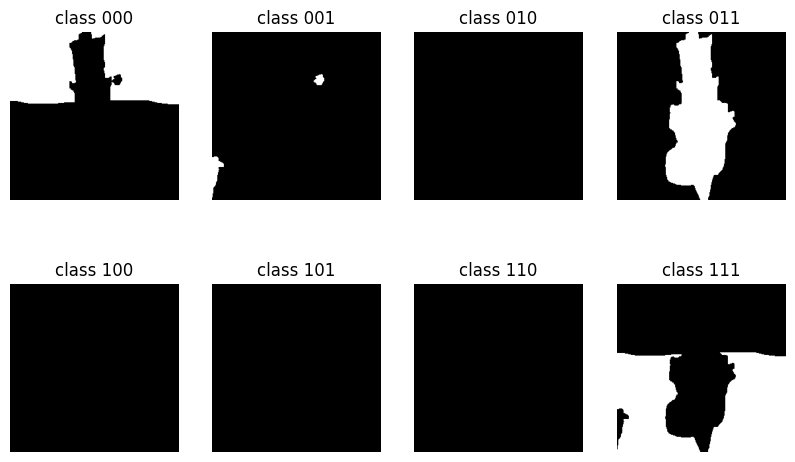

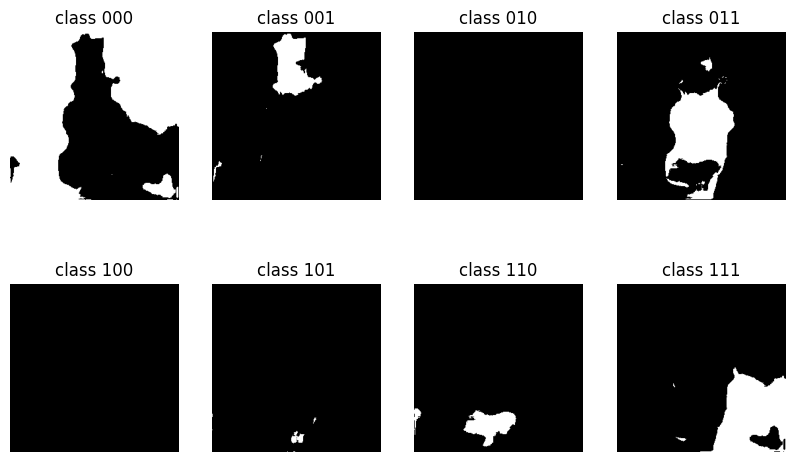

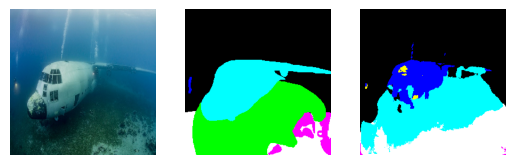

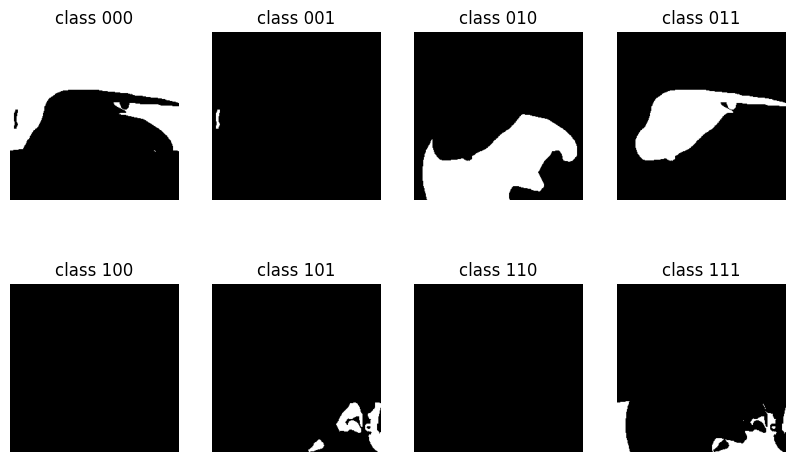

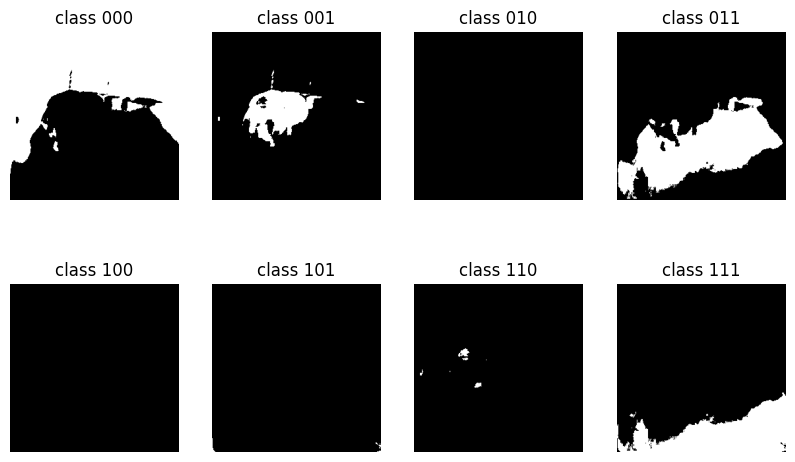

Test IoU = 0.6079945066096505
Channel IoU = [0.63741814 0.5849429  0.65988933 0.60183592 0.77696217 0.5724041
 0.6087263  0.62290182]
Test Pixel Accuracy = 0.7532650658062526


ValueError: too many values to unpack (expected 2)

In [58]:
model = torch.load(f'unet_best_loss.pt')
iou_scores_last, iou_bychannel_last = test_model(model)